In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

In [8]:
def GeneratePathsGBM(NoOfPaths, NoOfSteps, t1, T, sigma, lambda1, frate, corp, K, numeraire):
    #finding the 'dt' value the limits of integration are already fixed i.e., from s to T i.e., time to maturity
    dt = t1 / float(NoOfSteps)
    if T/dt != int(T/dt) or t1/dt != int(t1/dt):
      print("enter NoofSteps such that T and t1 are exact multiples of dt")
    time = np.arange(0,T+dt,dt)
    global NoOfSteps1
    NoOfSteps1 = NoOfSteps
    #generating standard normal distribution values for  'dW'
    Z = np.random.normal(0.0, 1.0, [NoOfPaths,len(time)])
    #creating vector for storing the interest rate values
    r = np.zeros([NoOfPaths, len(time) ])

    r[:, 0] = frate

    for i in range(0, len(time)-1):
      # Making sure that samples from a normal have mean 0 and variance 1
      if NoOfPaths > 1:
          Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])

      #finding the value of nut for each time interval
      nut = 0 + lambda1 * frate + (np.power(sigma,2) / (2 * lambda1)) * (1 - np.exp(-2 * lambda1 * time[i]))

      #finding value of interest rate at every time step
      if numeraire != "tforward":
        r[:,i+1] = r[:,i] + (nut - lambda1 * r[:,i]) * dt + sigma * np.power(dt,0.5) * Z[:, i]
      else:
        r[:,i+1] = r[:,i] + (nut - lambda1 * r[:,i] - np.power(sigma,2) * b(time[i])) * dt + sigma * np.power(dt,0.5) * Z[:, i]

    #defining functions for the exact bond price formula
    def fb(t,T):
      return (1/lambda1) * (1 - np.exp(-lambda1*(T - t)))

    def fa(t,T):
      return (np.exp(-1*frate*T)/np.exp(-1*frate*t)) * (np.exp(fb(t,T) * (frate) - (np.power(sigma,2)/(4 * lambda1)) * (1 - np.exp(-2 * lambda1 * t)) * np.power(fb(t,T),2)))

    value=np.zeros([NoOfPaths,len(time)])

    for i in range(0,len(time)):
      value[:,i] = fa(time[i],T)*np.exp(-fb(time[i],T)*frate)

    #finding the value of the bond at t=0 by integrating along the simulated paths
    disv = value[:,NoOfSteps] * np.exp(-1 * np.sum(r[:,0:NoOfSteps] * dt,axis=1))

    return {"disv":disv,"value":value,"dt":dt,"time":time}

In [9]:
# GeneratePathsGBM(NoOfPaths, NoOfSteps, t1, T, sigma, lambda1, frate, corp, K, numeraire)
k=GeneratePathsGBM(10, 5000, 5, 10, 0.01, 1, 0.1, "c", 0.95, "moneybank")

In [10]:
#disv is the array containing prices of the bond at t discounted to 0
k["disv"]

array([0.3589267 , 0.36934531, 0.35886102, 0.36935994, 0.362894  ,
       0.36994946, 0.37877655, 0.36763894, 0.37008509, 0.37268546])

In [17]:
#bond price using exact formula
k["value"][:,0]

array([0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944,
       0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944])

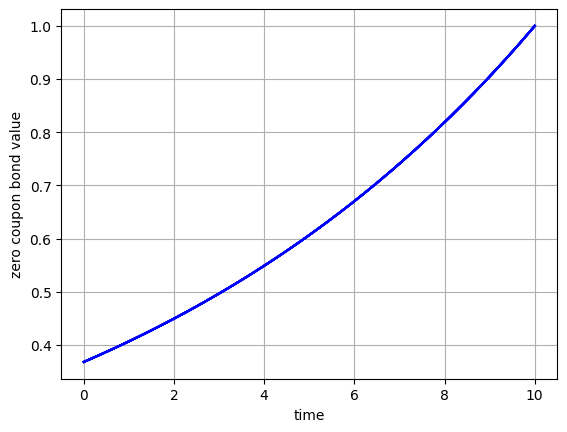

In [12]:
plt.figure(2)
plt.grid()
plt.xlabel("time")
plt.ylabel("zero coupon bond value")
# eSM_P = lambda t: S_0 * np.exp(mu * t) / M(t)
# plt.plot(time, eSM_P(time), 'r--')
plt.plot(k["time"][0:len(k["time"])], np.transpose(k["value"])[:,:], 'blue')